# Project 2: Ames Housing Price Analysis [Part II]

This is the second project done as part of the General Assembly's Data Science Immersive in June 2021.

This is the part II-of-II of the **Ames Housing Price Analysis** project. While in [part I](./ames-housing-analysis.ipynb) we explored the data, performed EDA and cleaned the data, here we will look into using the cleaned data to make predictions on the property sale prices using various **_Linear Regression_** models.


### Feature sets

We use the train and test dataset in this notebook, which were cleaned in the part I of this project. The original data had 80 features and a target feature to be predicted. After performing EDA and feature engineering, we condensed the data to 26 features, which are then subdivided into subsets of different combinations to be tested in the models. The feature set with the specific model giving best results would be selected and presented.

The following table shows the different feature sets evaluated:

|    |Feature sets|
|:--:|:----------:|
|**Set I**|LotFrontage, LotArea, OverallQual, MasVnrArea, ExterQual, BsmtQual, TotalBsmtSF, HeatingQC, GrLivArea, KitchenQual, OpenPorchSF, PropertyAge, TotalBedsNBaths, HasFireplace, HasWoodDeck, HasMasonryVeneer, FoundationPConc, FoundationCBlock, FoundationBrkTil, FoundationOthers|
|**Set II**| LotFrontage, LotArea, OverallQual, MasVnrArea, ExterQual, BsmtQual, TotalBsmtSF, HeatingQC, GrLivArea, KitchenQual, OpenPorchSF, PropertyAge, TotalBedsNBaths, GarageCarsNArea, HasFireplace, HasWoodDeck, GarageAttached, FoundationPConc, FoundationCBlock, FoundationBrkTil, NH_NAmes, NH_CollgCr, NH_OldTown, NH_Others, HouseStyle_1Story, HouseStyle_2Story |

After running the inital trial on Multiple Linear Regression with __Set I__, we noticed that the difference between __train__ and __valid__ $RMSE$ is more than ususal, thus, we need to revisit the feature selection in part I. The typical performance is that if the __train__ error is usually slightly lower than the __valid__ because the former was used to train the model. If it is too low, then we have _overfit_ issue where the model predicts the data it observed very well but fails to match with any new data that it sees, while if the train error is higher than the test data, the model is not quite accurate or the split between train/valid has some issues. We can confirmed this by _cross validating_.

The feature set, __Set II__, is eventually used to train all the models, with scaling for regularization models. The linearity of features with the target variable is also touched upon.

### Modeling

A _baseline_ score is calculated from the train data, which is simply the mean _SalePrice_ value from the train set used a predictor for target on test data. Then we build a Simple Linear Regression model using a single feature to see if we can do any better than the baseline, and reason about using multiple features in the linear regression models.

This is followed by a series of Multiple Linear Regressions, including the regularization models, __Ridge, Lasso and ElasticNet__. These models require the data to be scaled and typically eliminates the coefficients of features, by penalizing them, that are not contributing to the model prediction. We also fit some of the models with polynomial and interaction features generated by _sklearn's_ `PolynomialFeatures` method.

The coefficients from these models are interpreted and plotted to infer their impact on the target. After comparing the scores and errors for these models, the _best model_ is selected for deploying in production, when it is trained with the complete __train__ dataset.

### Contents

The contents of this notebook are as follows:

- [1 Data Import & Baseline Score](#1-Data-Import-&-Baseline-Score)
 * [1.1 Import the libraries](#1.1-Import-the-libraries)
 * [1.2 Calculate baseline score from train data](#1.2-Calculate-baseline-score-from-train-data)
 * [1.3 How to improve predictions? An SLR!](#1.3-How-to-improve-predictions?-An-SLR!)
- [2 Model Preparation](#2-Model-Preparation)
 * [2.1 Load the clean data](#2.1-Load-the-clean-data)
 * [2.2 Check linearity of features with target](#2.2-Check-linearity-of-features-with-target)
 * [2.3 Define feature and target variables](#2.3-Define-feature-and-target-variables)
 * [2.4 Scaling the features](#2.4-Scaling-the-features)
- [3 Model Fitting & Evaluation](#3-Model-Fitting-&-Evaluation)
 * [3.1 Multiple Linear Regression (MLR)](#3.1-Multiple-Linear-Regression-(MLR))
 * [3.2 Ridge Regression](#3.2-Ridge-Regression)
 * [3.3 Lasso Regression](#3.3-Lasso-Regression)
 * [3.4 ElasticNet Regression](#3.4-ElasticNet-Regression)
- [4 Production Model](#4-Production-Model)
- [5 Conclusions & Recommendations](#5-Conclusions-&-Recommendations)

## 1 Data Import & Baseline Score

### 1.1 Import the libraries

In [1]:
# standard numerical manipulation libraries
import numpy as np
import pandas as pd

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# plotting settings
%matplotlib inline
sns.set_style('whitegrid') # darkgrid
%config InlineBackend.figure_format = 'retina'

# modeling functions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# os module for file path
import os

In [2]:
# plot font settings
# Implented plot text sizes from- https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

**Function to save predictions in kaggle format**

In [3]:
# Define a function to get the SalePrice predictions and store it in kaggle format for submission
def get_kaggle_format(predictions=None, model_type='', return_df=False):
    # Get the Id column from test dataset
    test_id_column = (pd.read_csv('./../datasets/test_clean.csv'))['Id']
    
    # Make sure the predictions is an np.array
    if isinstance(predictions, float):
        predictions = np.ones_like(test_id_column) * predictions
    
    # Create a DataFrame with Id and predicted SalePrice for the test data
    result_df = pd.concat([test_id_column, pd.Series(predictions, name='SalePrice')], axis=1).sort_values(by='Id')
    
    # Output filename for kaggle submission
    i = 0
    while os.path.exists(f"./../datasets/kaggle_sub_{model_type}_{i}.csv"):
        i += 1
    filename = f"./../datasets/kaggle_sub_{model_type}_{i}.csv"
    
    # Save the DataFrame to a file
    result_df.to_csv(filename, index=False)
    
    # Return the results DataFrame
    if return_df:
        return result_df

### 1.2 Calculate baseline score from train data

For a basic baseline score, we will use the mean value of _SalePrice_ from train data as the predictions for test data. This is the simplest way to predict.

In [4]:
# import the original dataset and get the mean of SalePrice from train data
y_train_baseline = (pd.read_csv('./../datasets/train_clean.csv'))['SalePrice']
y_valid_baseline = (pd.read_csv('./../datasets/valid_clean.csv'))['SalePrice']

y_bar_baseline = np.mean(y_train_baseline)
y_bar_baseline

179698.67804878048

The mean _SalePrice_ for the train data is $\$179698.67$, which we use as the predicted target value for test data to calculate the base score.

In [5]:
# Get the kaggle format dataframe
df_baseline_results = get_kaggle_format(y_bar_baseline, model_type='baseline', return_df=True)
df_baseline_results.head()

,Id,SalePrice
704,2,179698.678049
706,4,179698.678049
120,6,179698.678049
312,7,179698.678049
401,17,179698.678049


In [6]:
# RMSE for the train data
y_preds_baseline = np.ones_like(y_train_baseline) * y_bar_baseline
print(np.sqrt(mean_squared_error(y_true=y_train_baseline, y_pred=y_preds_baseline)))

77014.97062130462


In [7]:
# RMSE for the valid data
y_preds_baseline = np.ones_like(y_valid_baseline) * y_bar_baseline
np.sqrt(mean_squared_error(y_true=y_valid_baseline, y_pred=y_preds_baseline))

82507.10610284265

The baseline $RMSE$ from our mean used as a prediction on __train__ set is $\$77014.97$ and for __valid__ set is $\$82507.10$, and both of them are comparable as that's what we expect. The one from kaggle on the __test__ set is $\$80259.83$. So, this is our baseline score, now let's see how we can improve this.

We will keep updating the following error table as we get new values from different models.

| Predictor|        Features         | Train RMSE | Valid RMSE |
|:--------:|:-----------------------:|:----------:|:----------:|
| Baseline | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |

### 1.3 How to improve predictions? An SLR!

Let's attempt to beat the baseline score using a **_Simple Linear Regression (SLR)_** model on vanilla data (no cleaning), where
$$X = \text{LotArea},\ y = \text{SalePrice}$$

The size of the property is a direct indicator of its price, and thus it makes sense to use _Lot Area_ in our simple SLR to get the scores. We will use $R^2$, $\text{adj-}R^2$, $\text{MAE}$ and $\text{RMSE}$ as performance metrics to compare the various regression models, as they are commonly used for the output for regression models.

**Note:** Since we don't have the $\text{true}$ values for _SalePrice_ in the *test.csv*, we will only determine the baseline score for the *train.csv* by spliting into *train* and *valid* sets.

In [8]:
# Define a function to calculate adjusted-R2
def get_adj_r2(_model, _X, _y, n, k):
    # calculate r2
    r2 = _model.score(_X, _y)
    
    # return the adj-r2
    return round((1 - ((1 - r2) * (n - 1)/(n - k - 1))), 5)

In [9]:
# Define a function to get the performance metrics
def get_reg_metrics(_model, _X, _y):
#     model.fit(X, y)
    
    # calculate the predicted y from the model, X and y
    _y_pred = _model.predict(_X)
    
    # Print the values for R-squared and RMSE
    print(f'R-squared: {round(_model.score(_X, _y), 5)} | Ajusted R-squared: {get_adj_r2(_model, _X, _y, len(_y), _X.shape[1])}')
    print(f'Mean absolute error: {round(mean_absolute_error(y_pred=_y_pred, y_true=_y), 5)}')
    print(f'Root mean squared error: {round(np.sqrt(mean_squared_error(y_pred=_y_pred, y_true=_y)), 5)}')

In [10]:
# Get the X & y from train_clean and valid_clean
X_slr_train = pd.read_csv('./../datasets/train_clean.csv')[['LotArea']]
y_slr_train = pd.read_csv('./../datasets/train_clean.csv')['SalePrice']

X_slr_valid = pd.read_csv('./../datasets/valid_clean.csv')[['LotArea']]
y_slr_valid = pd.read_csv('./../datasets/valid_clean.csv')['SalePrice']

In [11]:
# Get the test X from test.csv
X_slr_test = pd.read_csv('./../datasets/test_clean.csv')[['LotArea']]

**Using sklearn's LinearRegression**

In [12]:
# Define the model
model_slr = LinearRegression()

# Fit the model with training data
model_slr.fit(X_slr_train, y_slr_train)

LinearRegression()

In [13]:
# Print the performance metrics -- train set
get_reg_metrics(model_slr, X_slr_train, y_slr_train)

R-squared: 0.10579 | Ajusted R-squared: 0.10506
Mean absolute error: 53754.52486
Root mean squared error: 72827.35495


In [14]:
# Print the performance metrics -- valid set
get_reg_metrics(model_slr, X_slr_valid, y_slr_valid)

R-squared: 0.15811 | Ajusted R-squared: 0.15708
Mean absolute error: 54861.22567
Root mean squared error: 75595.17955


In [15]:
# Check the cross validation score for this model
np.sqrt(-cross_val_score(model_slr, X=X_slr_train, y=y_slr_train, cv=10, scoring='neg_mean_squared_error').mean())

73073.1047801821

The low values of $R^2$ and $\text{adj-}R^2$ means the predicted values have a very high variance and residuals to the true values. The $RMSE$ of our train set is $\$72827.35$ and valid set is $\$75595.17$, which is an improvement from the baseline values. Let's update the error table:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|<span style="color:blue">SLR</span>|  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |

The above values for our vanilla Simple Linear Regression model means there is much room for improvement. The low $R^2$ score clearly points to the fact that the model is way too simple and needs more features  and/or interactions to be considered. The $RMSE$ is a measure of average error in _SalePrice_ as predicted by the model, in the same units. The errors are slightly higher for valid dataset as the predicted value was calculated using the train dataset. The $MAE$ for both train and valid datasets are similar in this case. The cross-validation score, as the name suggests, validates that the model performs similarly for un-seen data.

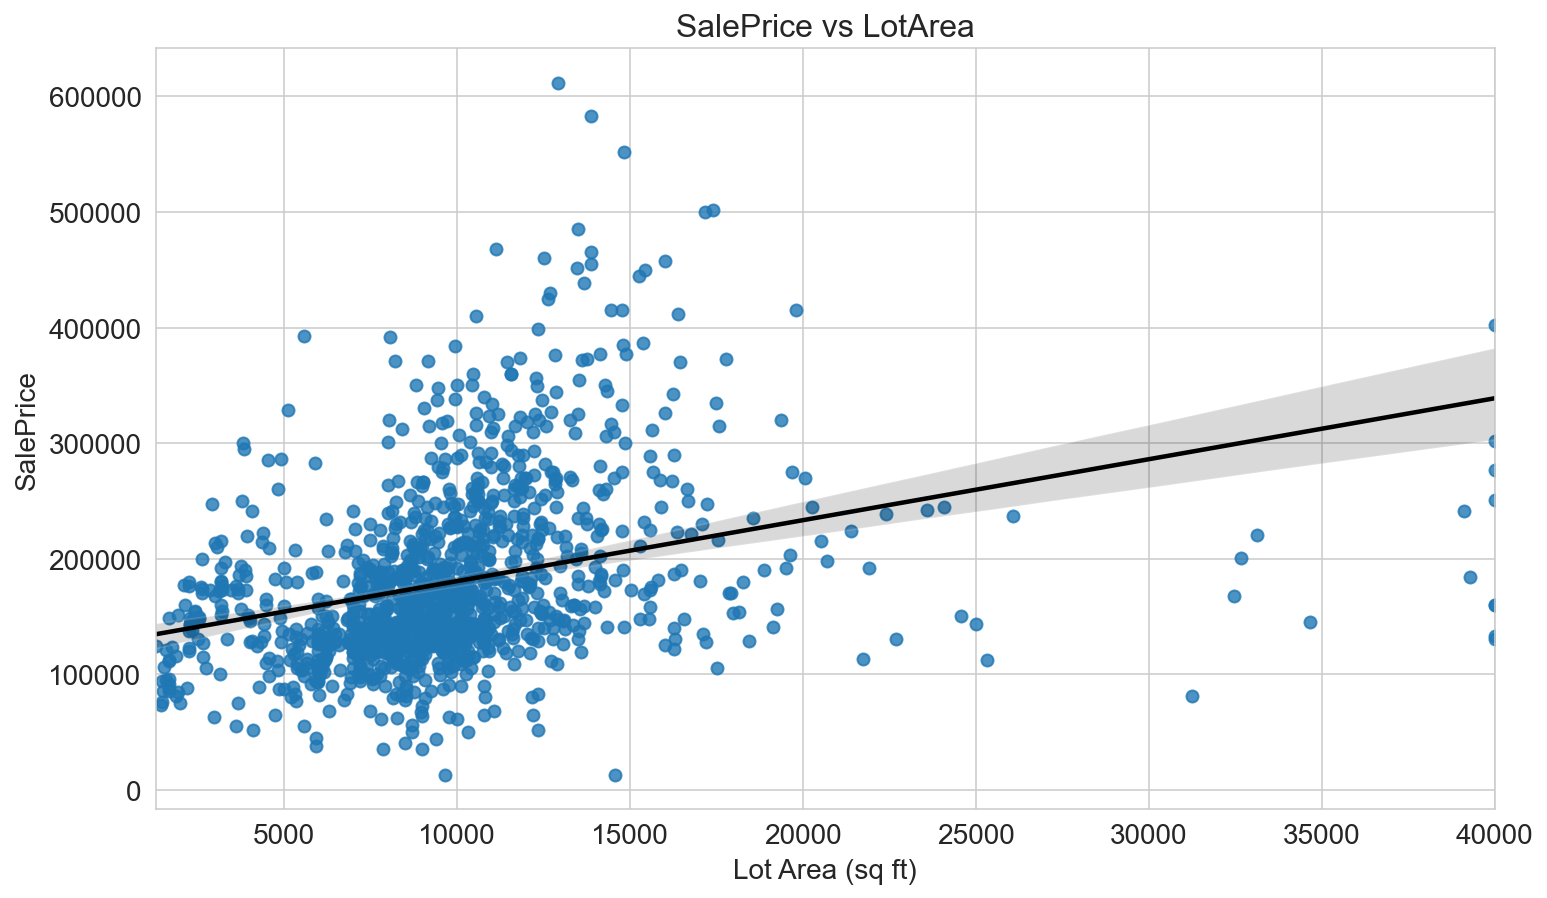

In [16]:
# plot the SalePrice vs LotArea regression graph
plt.figure(figsize=(12, 7))
plt.title('SalePrice vs LotArea')
sns.regplot(x=X_slr_train, y=y_slr_train, line_kws={"color": "black"})
plt.xlabel('Lot Area (sq ft)');

A regression plot between the feature ($X$) and target ($y$) shows that the variance in error increases for higher valued predictions and it isn't a clearly linear relationship between the two variables.

__Let's move to next section for more complex model with feature selction.__

## 2 Model Preparation

Start by importing the clean datasets, defining the feature set $X$ & target variable $y$, and scaling the required features.

### 2.1 Load the clean data

In [17]:
# Load the clean train, valid & test dataset
df_train = pd.read_csv('./../datasets/train_clean.csv')
df_valid = pd.read_csv('./../datasets/valid_clean.csv')
df_test = pd.read_csv('./../datasets/test_clean.csv')

In [18]:
df_train.shape

(1230, 28)

In [19]:
df_valid.shape

(821, 28)

In [20]:
df_test.shape

(879, 27)

In [21]:
# All the features that will be used for building the models
[col for col in df_train.columns if col != 'Id' and col != 'SalePrice']

['LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 'HeatingQC',
 'GrLivArea',
 'KitchenQual',
 'OpenPorchSF',
 'PropertyAge',
 'TotalBedsNBaths',
 'GarageCarsNArea',
 'HasFireplace',
 'HasWoodDeck',
 'GarageAttached',
 'FoundationPConc',
 'FoundationCBlock',
 'FoundationBrkTil',
 'NH_NAmes',
 'NH_CollgCr',
 'NH_OldTown',
 'NH_Others',
 'HouseStyle_1Story',
 'HouseStyle_2Story']

### 2.2 Check linearity of features with target

Inherently not all features would have a linear relationship with the target we are trying to predict using the linear regression methods. Thus, it is crucial to point out here this point to explore some of them and make changes to them if necessary.

In [22]:
# Define a function to draw a regression line on SalePrice vs features
def reg_plot_with_target(feature, title=None):
    plt.figure(figsize=(10, 5))
    plt.title(f'SalePrice vs {feature}')
    sns.regplot(x=df_train[feature], y=df_train['SalePrice'], line_kws={"color": "black"})
    plt.xlabel(feature);

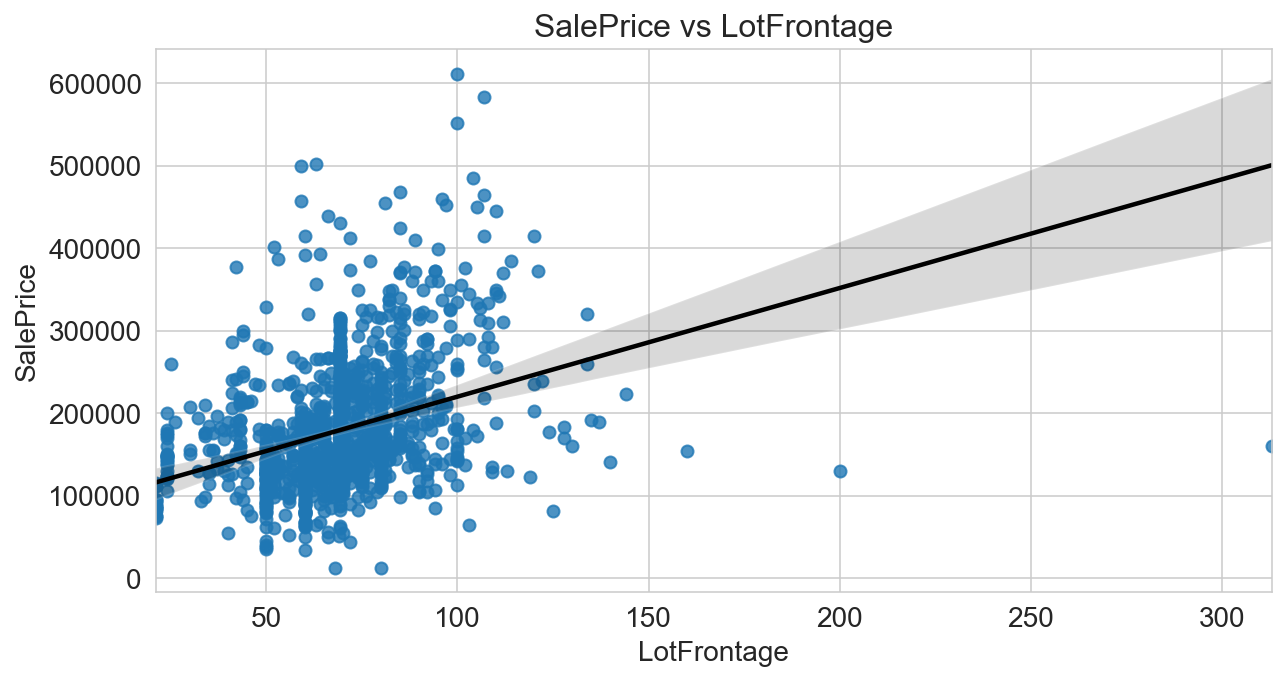

In [23]:
# Lot Frontage
reg_plot_with_target('LotFrontage')

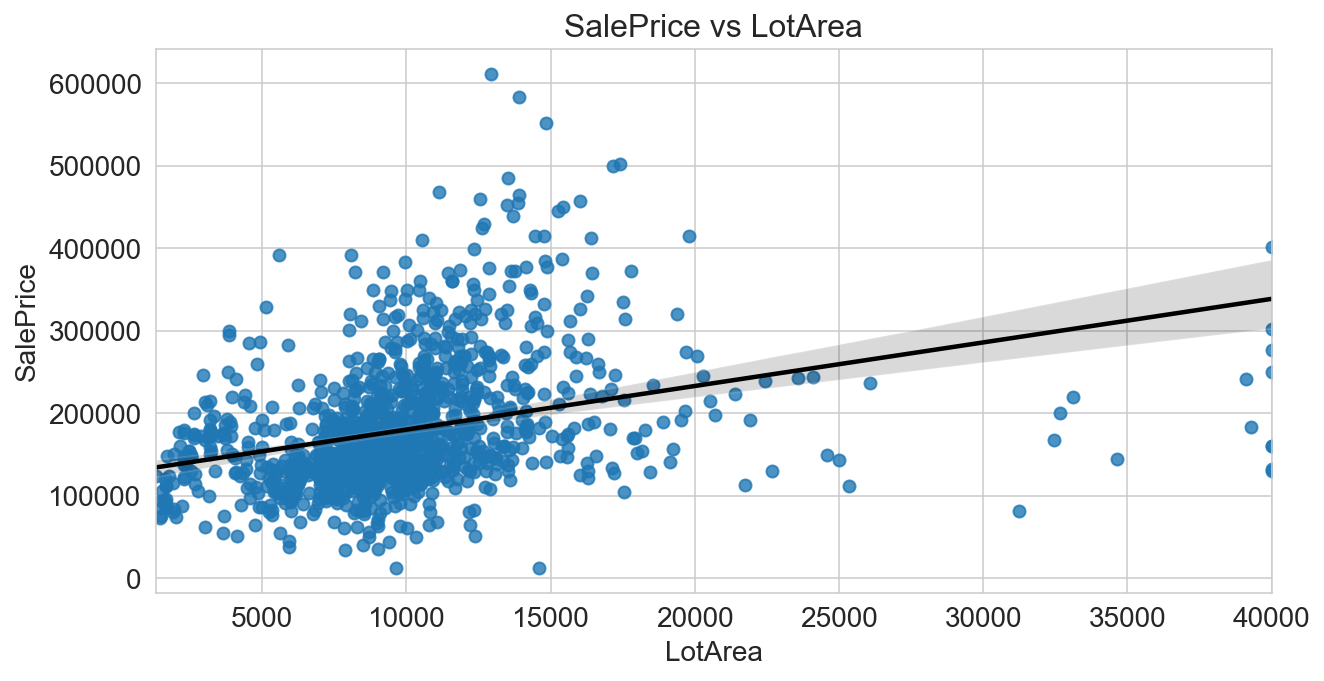

In [24]:
# Lot Area
reg_plot_with_target('LotArea')

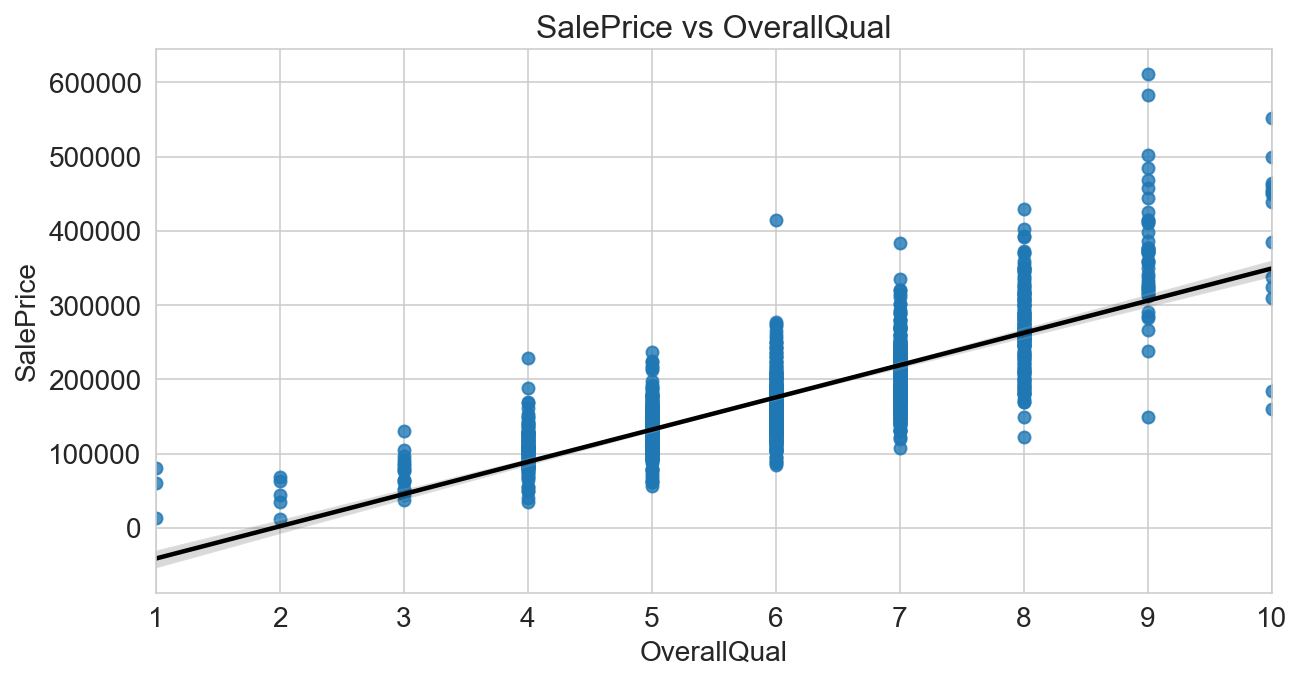

In [25]:
reg_plot_with_target('OverallQual')

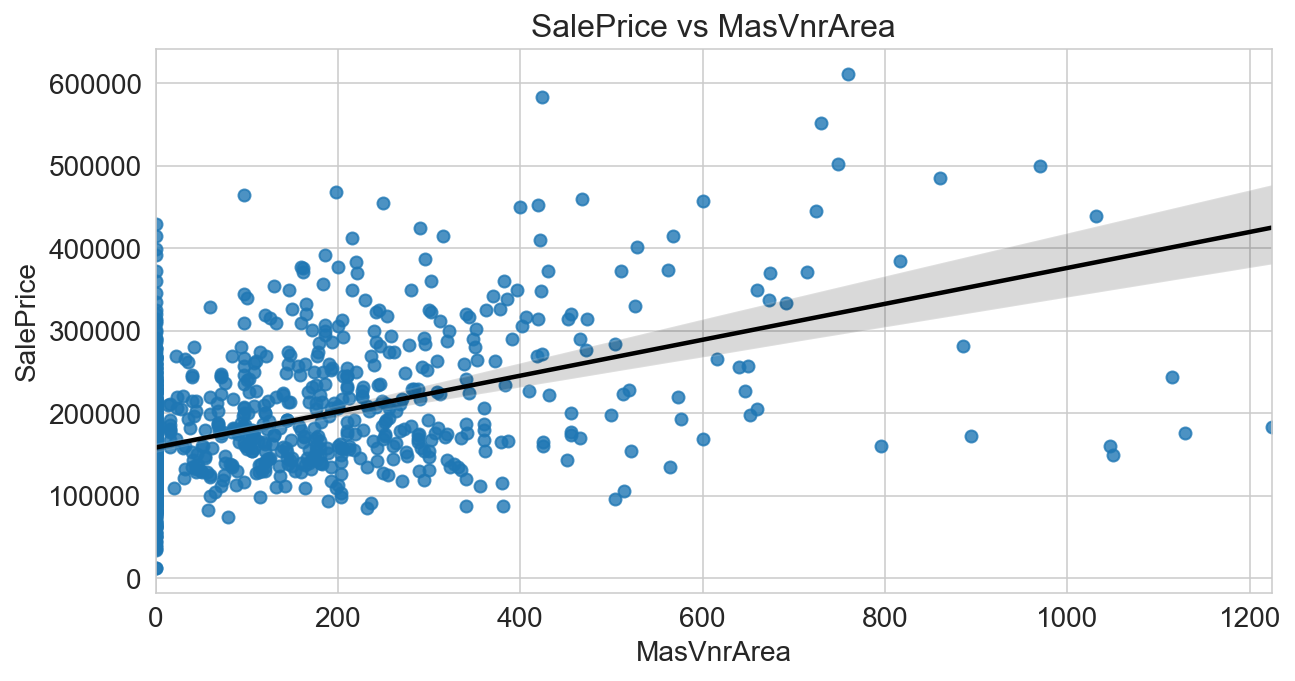

In [26]:
reg_plot_with_target('MasVnrArea')

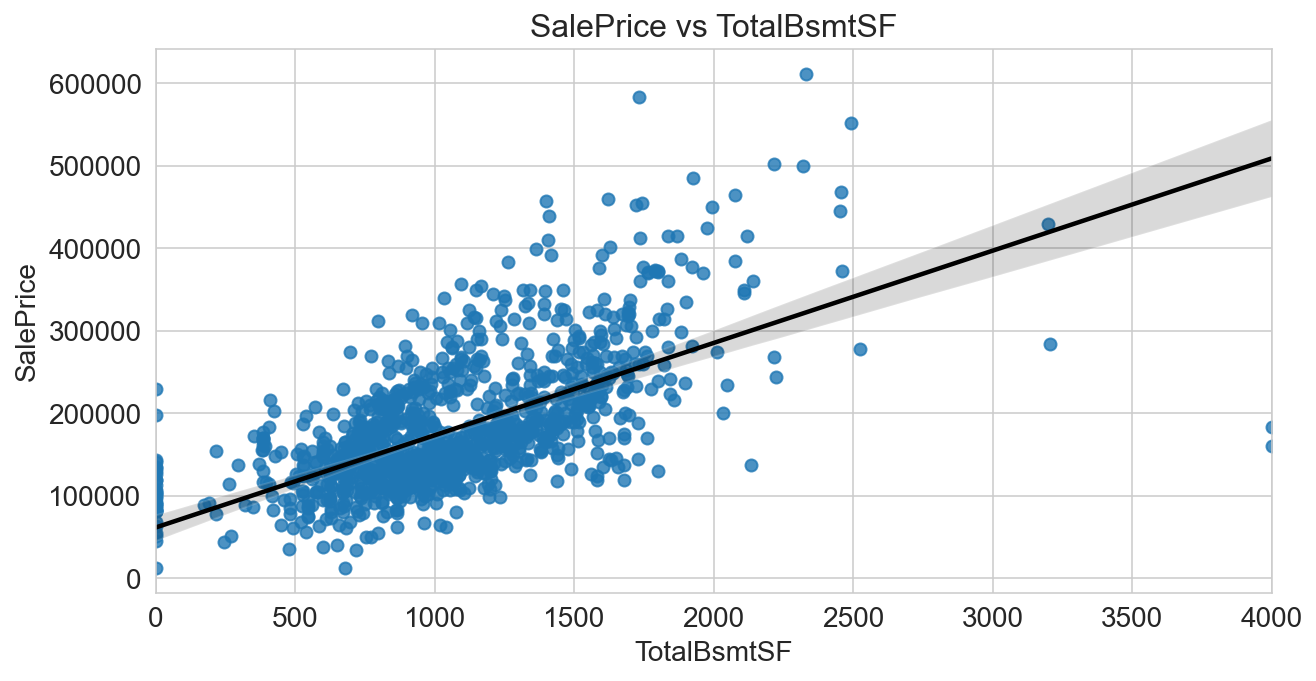

In [27]:
reg_plot_with_target('TotalBsmtSF')

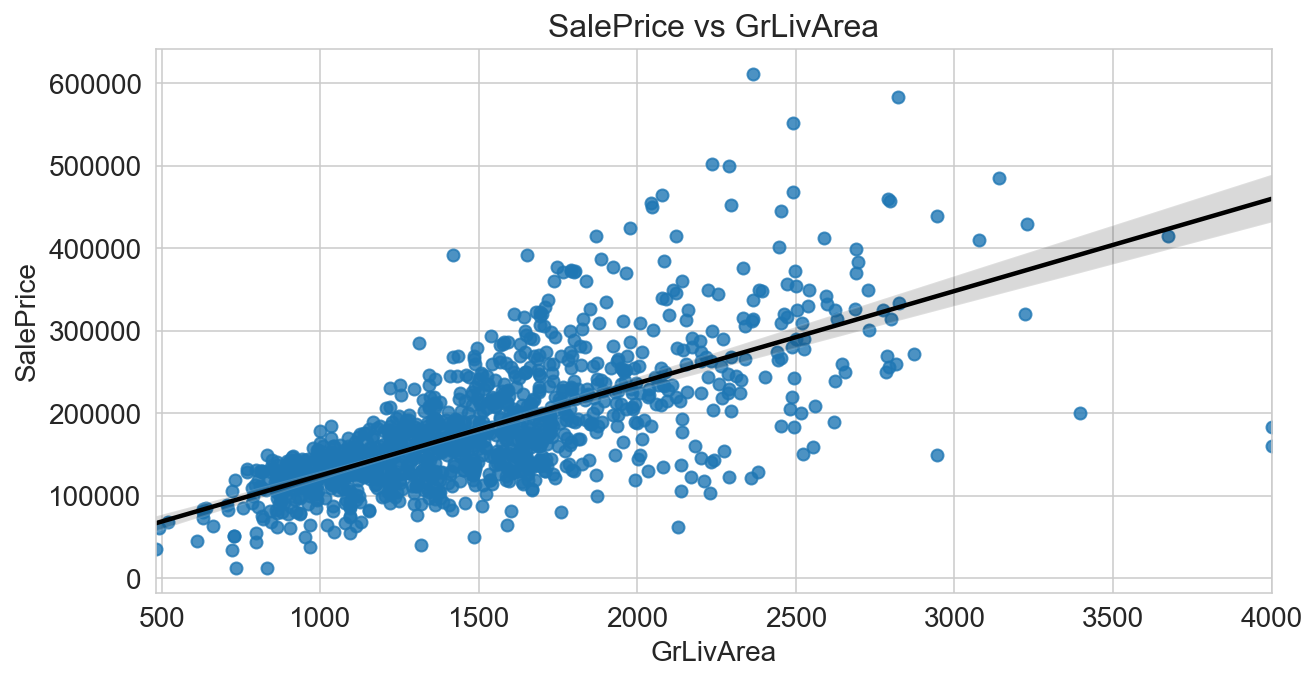

In [28]:
reg_plot_with_target('GrLivArea')

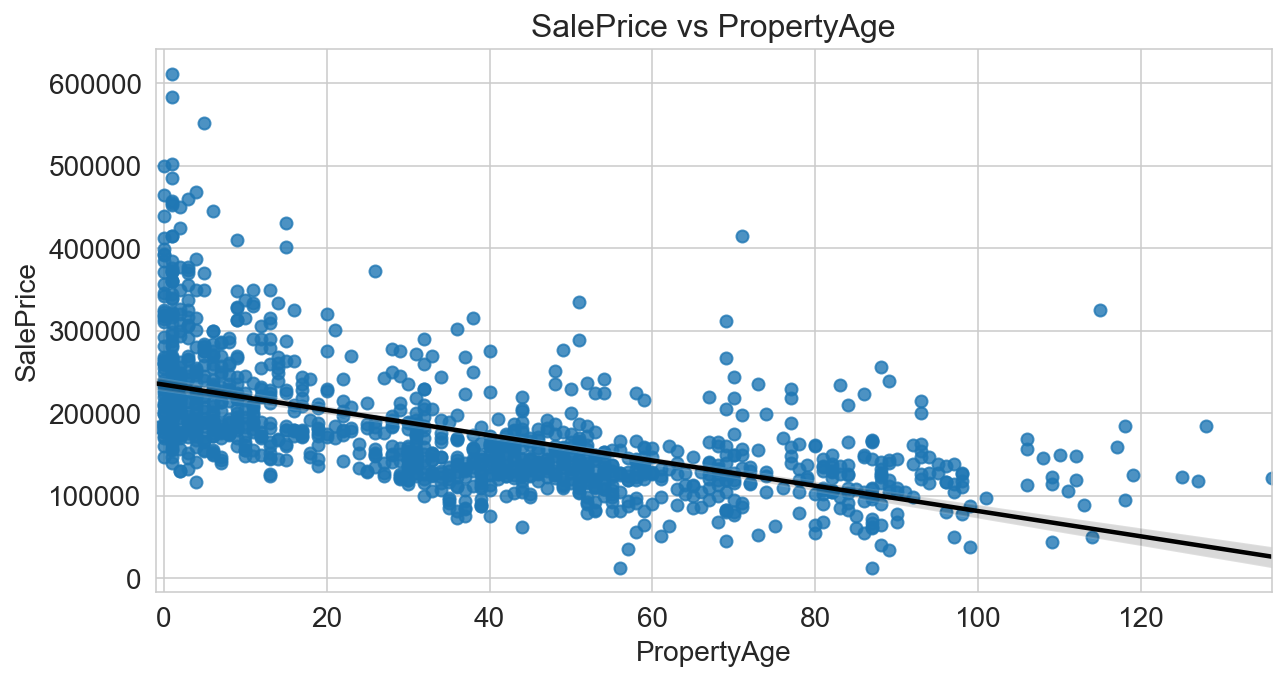

In [29]:
reg_plot_with_target('PropertyAge')

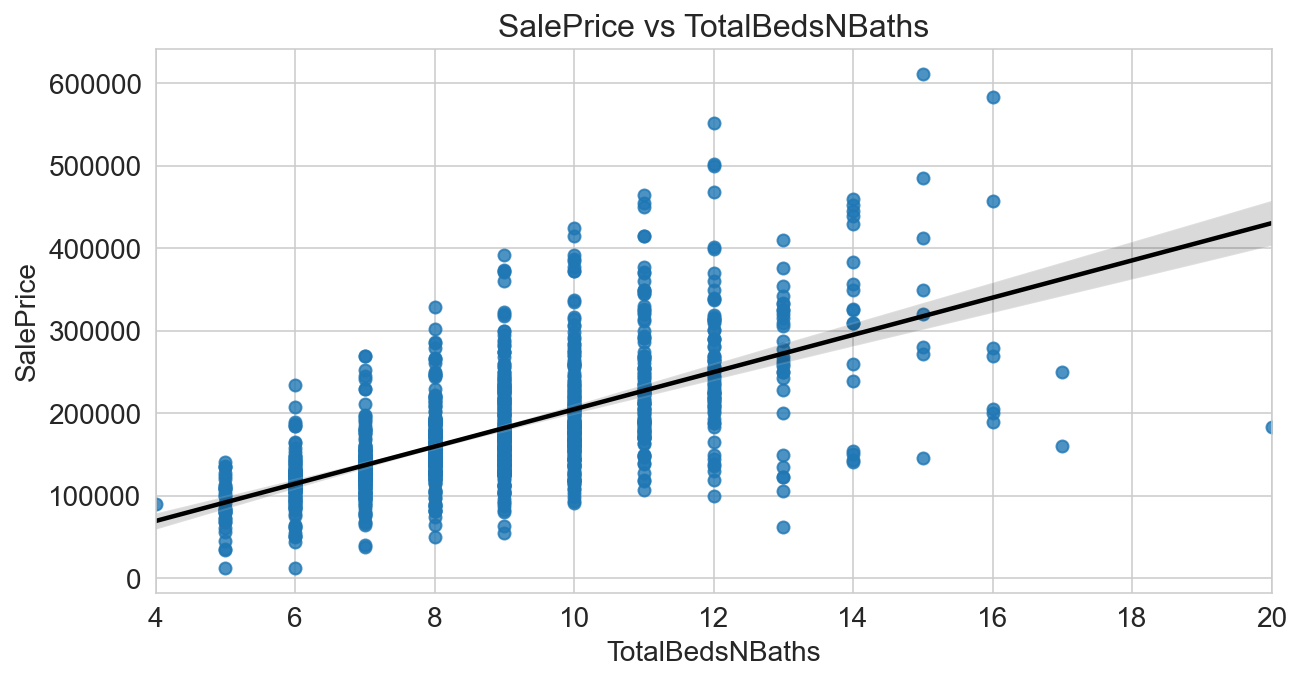

In [30]:
reg_plot_with_target('TotalBedsNBaths')

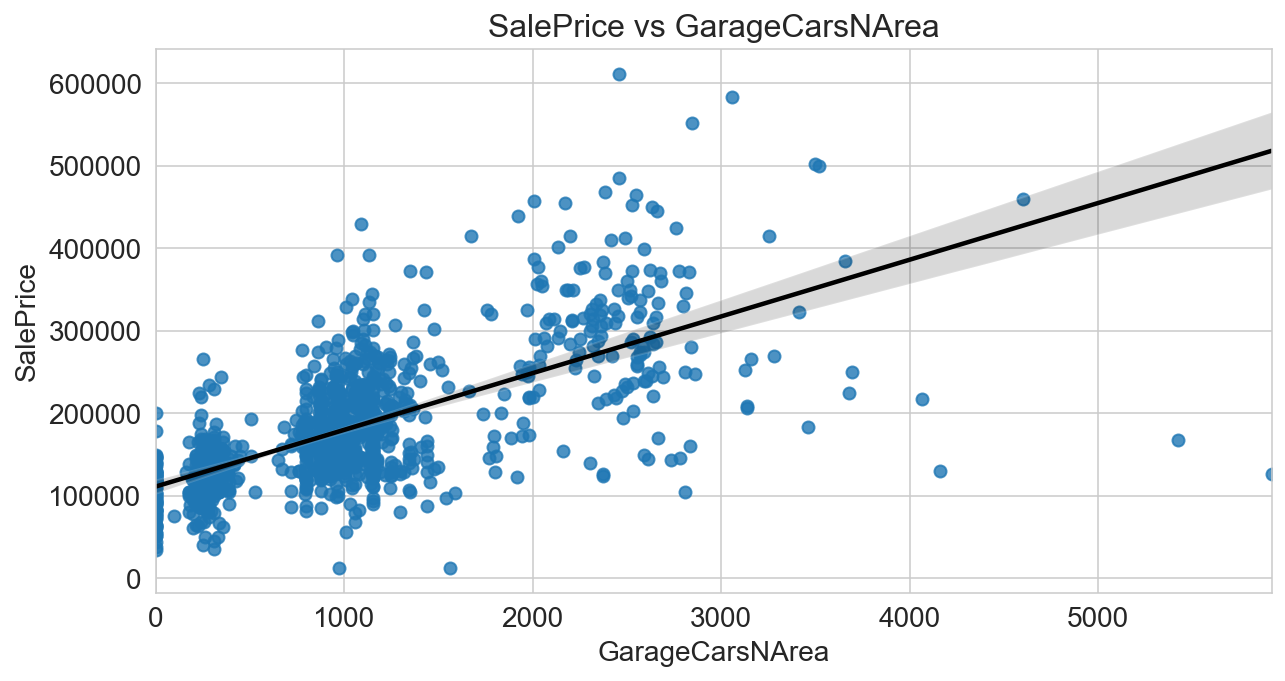

In [31]:
reg_plot_with_target('GarageCarsNArea')

As we can see from the plots above, most of them follow a linear relationship with the target but the varying degree of fit. The _best fit_ lines for some is close fit than others and this is a sign that some of these features might have non-linear relatin with the target variable. This can be dealt with by looking at each feature individually and using the best line/curve that fits the data, which can be really expensive and time cosuming, or we can simply apply a polynomial feature to all features, use lasso regularization and see which ones are non-zero. The second method is the one employed for the purposes of this project. 

### 2.3 Define feature and target variables

Here we define the features ($X$) that we use to train the various models, and the target variable ($y$), that we predict using the models.

In [32]:
# Define the X and y for the model building
# train set
X_train = df_train.drop(columns=['Id', 'SalePrice'])
y_train = df_train['SalePrice']

# valid set
X_valid = df_valid.drop(columns=['Id', 'SalePrice'])
y_valid = df_valid['SalePrice']

# test set
X_test = df_test.drop(columns=['Id'])

# Initialize the scaled dataframes
X_train_sc = X_train.copy()
X_valid_sc = X_valid.copy()
X_test_sc = X_test.copy()

### 2.4 Scaling the features

Later when we perform regularization using the Ridge, Lasso and ElasticNet regression methods, we would need to supply scaled values of feature to them. So we us **sklearn's** `StandardScaler` method to scale the non-binary features in our dataset.

In [33]:
# List of columns that needs scaling (from part I)
scale_cols = ['LotFrontage',
              'LotArea',
              'OverallQual',
              'MasVnrArea',
              'ExterQual',
              'BsmtQual',
              'TotalBsmtSF',
              'HeatingQC',
              'GrLivArea',
              'KitchenQual',
              'OpenPorchSF',
              'PropertyAge',
              'TotalBedsNBaths',
              'GarageCarsNArea']

In [34]:
# Instantiate the StandardScaler()
ss = StandardScaler()

# Fit and transform the train set
X_train_sc[scale_cols] = ss.fit_transform(X_train[scale_cols])

# Transform the valid and test sets
X_valid_sc[scale_cols] = ss.transform(X_valid[scale_cols])
X_test_sc[scale_cols] = ss.transform(X_test[scale_cols])

In [35]:
# Instantiate the PolynomialFeatures()
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Fit and transform the train set
X_train_poly = poly.fit_transform(X_train_sc)

# Transform the valid and test sets
X_valid_poly = poly.transform(X_valid_sc)
X_test_poly = poly.transform(X_test_sc)

## 3 Model Fitting & Evaluation

### 3.1 Multiple Linear Regression (MLR)

We start by building the multi-variable version of the Linear Regression to build on the model in this [section](#1.3-How-to-improve-predictions?-An-SLR!). We will build one model without scaling, one with scaling later, and one with polynomial features.

#### With unscaled data

In [36]:
# Instantiate the model and fit the train data
model_mlr = LinearRegression()
model_mlr.fit(X=X_train, y=y_train)

LinearRegression()

In [37]:
# Print the performance metrics -- train set
get_reg_metrics(_model=model_mlr, _X=X_train, _y=y_train)

R-squared: 0.83375 | Ajusted R-squared: 0.83015
Mean absolute error: 20561.86298
Root mean squared error: 31402.10521


In [38]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=model_mlr, _X=X_valid, _y=y_valid)

R-squared: 0.85538 | Ajusted R-squared: 0.85064
Mean absolute error: 21427.32592
Root mean squared error: 31331.72269


This shows a great order of improvement over the SLR, and confirms that considering other features would give structure to our model and more prediting power. The $MAE$ and $RMSE$ are reduced by over half that of SLR.

In [39]:
# Create a DataFrame of coefficients that model calculated
pd.DataFrame(model_mlr.coef_, columns=['Coefficient'], index=X_train.columns).T

,LotFrontage,LotArea,OverallQual,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,KitchenQual,...,GarageAttached,FoundationPConc,FoundationCBlock,FoundationBrkTil,NH_NAmes,NH_CollgCr,NH_OldTown,NH_Others,HouseStyle_1Story,HouseStyle_2Story
Coefficient,14.786325,0.709717,11844.361272,15.060294,14064.274484,16061.08123,15.54652,2562.075211,38.621073,13085.968329,...,1197.364014,-2706.973871,-3174.721648,-6333.131183,4102.685293,-5338.35659,-6373.495018,1235.671297,5451.088798,-5431.209543


These are the coefficient values that show how much impact each individual feature has on the price. Higher the coefficient, bigger the contribution to target. A positive value means a positive correlation between the feature and target. The top five coefficients with most contribution to target are: _BsmtQual, ExterQual, KitchenQual, HasFireplace, and OverallQual_. These coefficient value ($\beta_X$) means that one unit increase in feature value, raises the predicted SalePrice of the property by $\beta_X$ amount, e.g., 1 unit increase in _BsmtQual_ of house would raise its predicted price by $\$16061.08$. On the other hand, having a house in the neighborhoods of OldTown and a 2Story property reduces the property sale price by respective amounts.

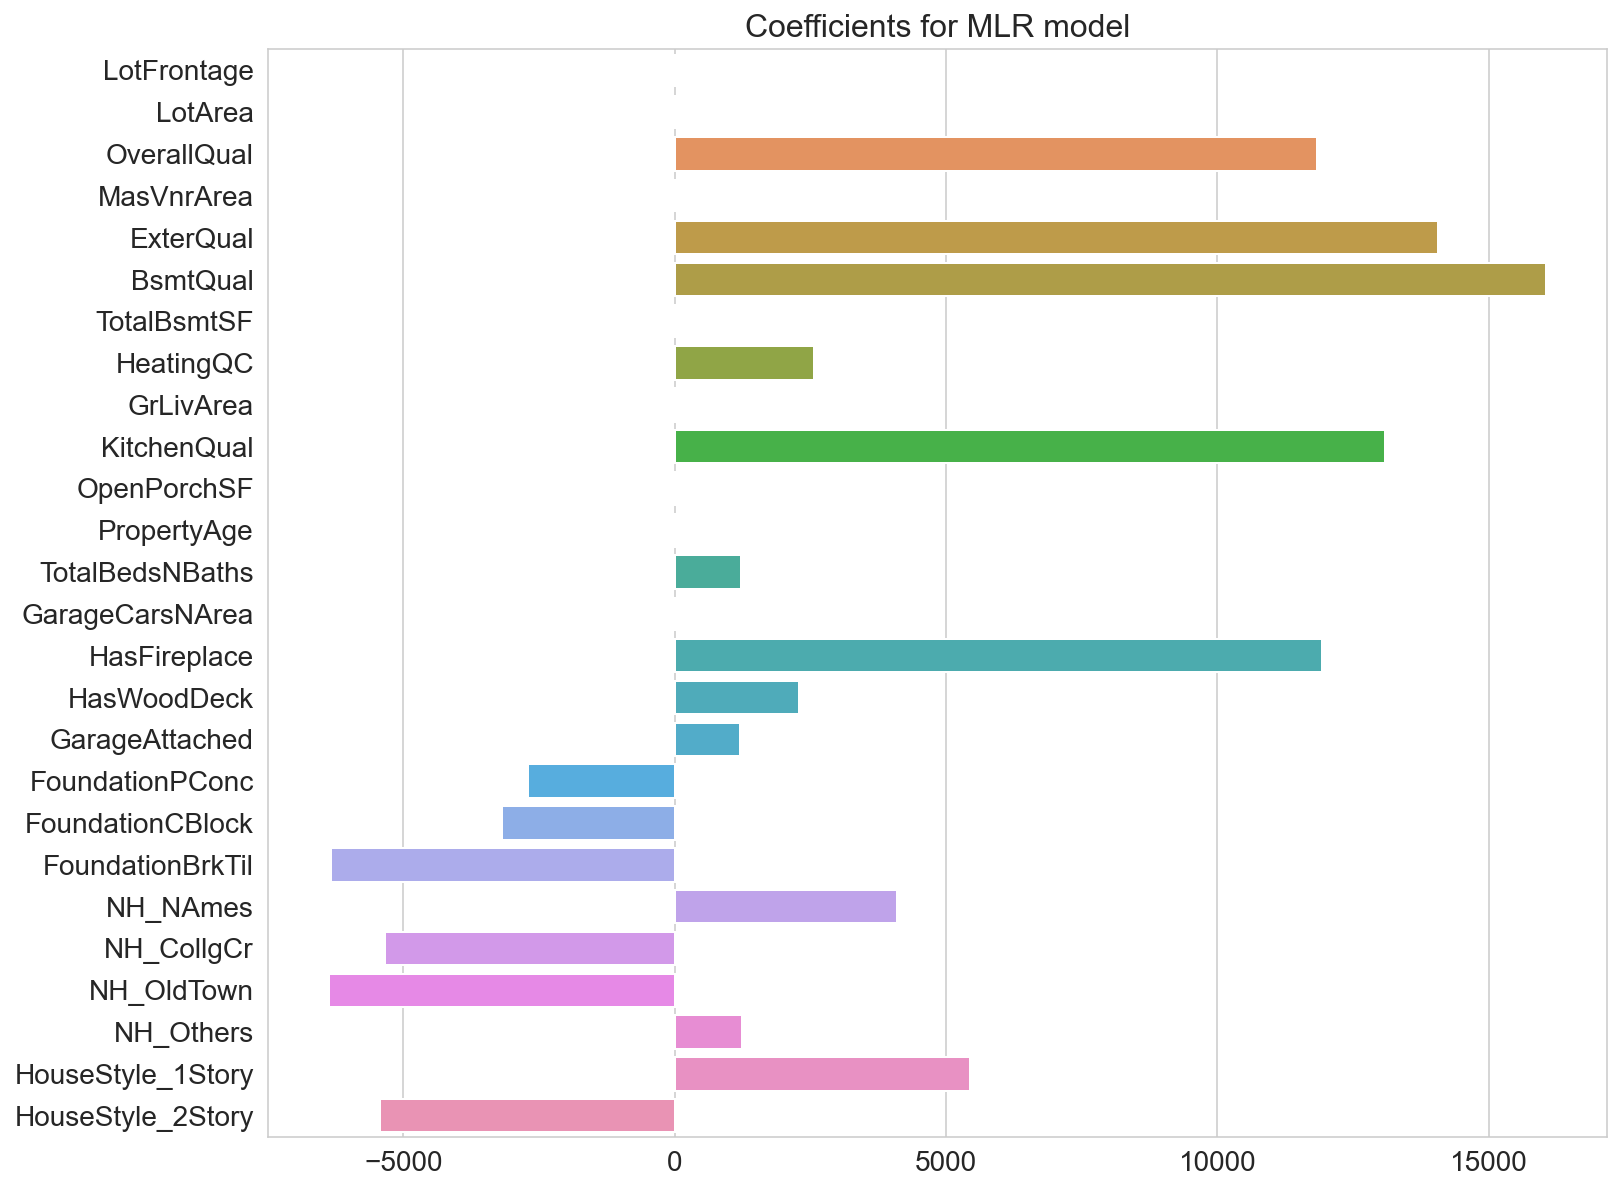

In [87]:
res = pd.DataFrame(model_mlr.coef_, columns=['Coefficient'], index=X_train.columns).T

# Plot the coefficients
plt.figure(figsize=(12, 10))
# plt.xticks(rotation=90)
plt.title('Coefficients for MLR model')
sns.barplot(data=res, orient='h');

As can be clearly seen, many coefficients are near 0 and do not contribute to predicting the target variable. For sanity check, we can compare results with scaled $X$.

#### With scaled data

In [41]:
# Instantiate the model and fit the train data
model_mlr_sc = LinearRegression()
model_mlr_sc.fit(X=X_train_sc, y=y_train)

LinearRegression()

In [42]:
# Print the performance metrics -- train set
get_reg_metrics(_model=model_mlr_sc, _X=X_train_sc, _y=y_train)

R-squared: 0.83375 | Ajusted R-squared: 0.83015
Mean absolute error: 20561.86298
Root mean squared error: 31402.10521


In [43]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=model_mlr_sc, _X=X_valid_sc, _y=y_valid)

R-squared: 0.85538 | Ajusted R-squared: 0.85064
Mean absolute error: 21427.32592
Root mean squared error: 31331.72269


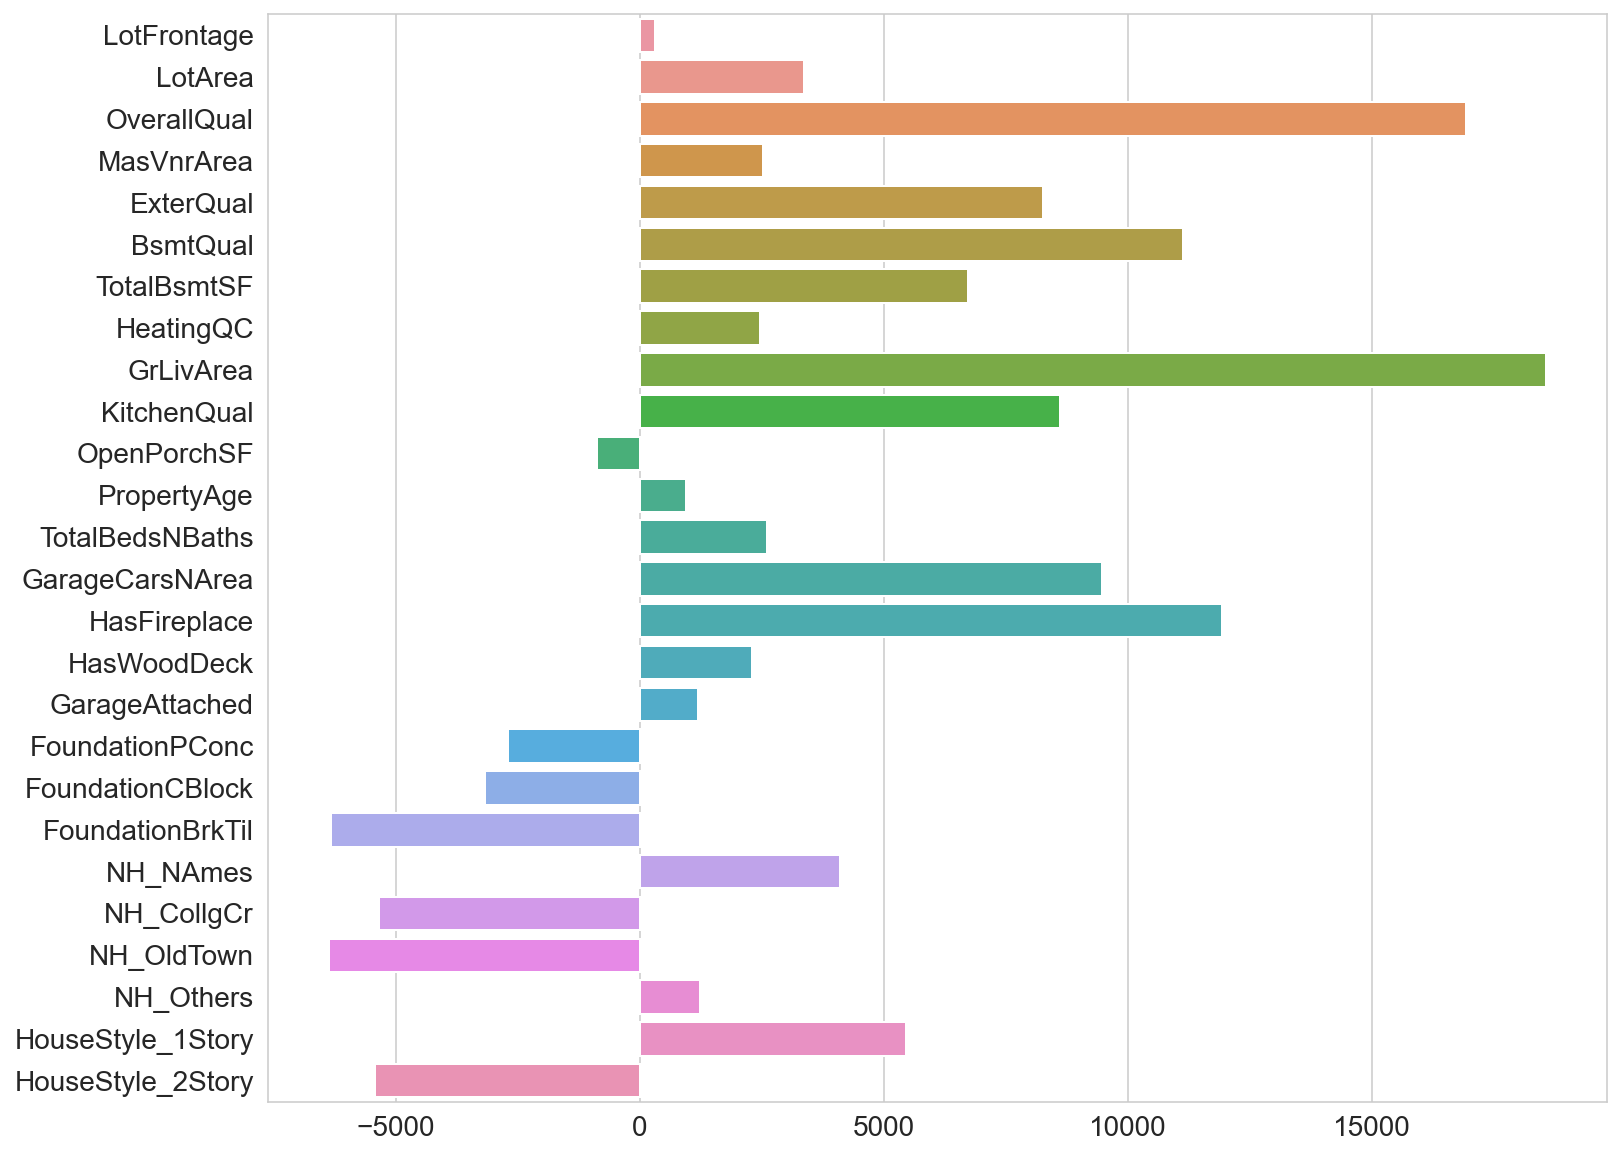

In [44]:
res = pd.DataFrame(model_mlr_sc.coef_, columns=['Coefficient'], index=X_train.columns).T

# Plot the coefficients
plt.figure(figsize=(12, 10))
# plt.xticks(rotation=90)
plt.title('Coefficients for MLR model (scaled data)')
sns.barplot(data=res, orient='h');

We get exact error terms, which is not a surprise as scaling simply standardizes the feature values and has no effect on the model itself. Obviously the coefficients change because now the scaling is in play, and yet another varification can be done using `cross_val_score` on the train dataset.

#### Cross Validation score for MLR

In [45]:
# Calculate the mean RMSE for MLR model
np.sqrt(-cross_val_score(estimator=model_mlr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='neg_mean_squared_error').mean())

33546.18927996523

A mean $RMSE$ of $33546.18$ from cross-validating on __train__ set for MLR confirms that indeed the model performance is accetable as it produces consistent results for prediting unseen data.

The error table with updated values from different features sets tried is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|<span style="color:blue">MLR</span>|  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |

The model highlighted in blue is best so far.

#### With polynomial features

In [46]:
# Instantiate the model and fit the train data
model_mlr_poly = LinearRegression()
model_mlr_poly.fit(X=X_train_poly, y=y_train)

LinearRegression()

In [47]:
# Print the performance metrics -- train set
get_reg_metrics(_model=model_mlr_poly, _X=X_train_poly, _y=y_train)

R-squared: 0.93978 | Ajusted R-squared: 0.9157
Mean absolute error: 13757.18449
Root mean squared error: 18899.71903


In [48]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=model_mlr_poly, _X=X_valid_poly, _y=y_valid)

R-squared: 0.83888 | Ajusted R-squared: 0.7183
Mean absolute error: 22561.56662
Root mean squared error: 33070.5875


Although the errors for train data are significantly lower, the same performance cannot be seen in valid data and thus this model is imperfect. The error table with updated values from different features sets tried is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|<span style="color:blue">MLR</span>|  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|MLR (poly) |  Set II                 |  18899.71  |  33070.58  |   0.93978 / 0.83888   |       -        |

The model highlighted in blue is best so far.

### 3.2 Ridge Regression

In [49]:
# Instantiate and fit the model
r_alphas = np.logspace(0, 10, 200)
ridgecv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=10)
ridgecv.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12266777e+00, 1.26038293e+00, 1.41499130e+00,
       1.58856513e+00, 1.78343088e+00, 2.00220037e+00, 2.24780583e+00,
       2.52353917e+00, 2.83309610e+00, 3.18062569e+00, 3.57078596e+00,
       4.00880633e+00, 4.50055768e+00, 5.05263107e+00, 5.67242607e+00,
       6.36824994e+00, 7.14942899e+00, 8.02643352e+00, 9.01101825e+00,
       1.01163798e+01, 1.13573336e+0...
       6.98587975e+08, 7.84282206e+08, 8.80488358e+08, 9.88495905e+08,
       1.10975250e+09, 1.24588336e+09, 1.39871310e+09, 1.57029012e+09,
       1.76291412e+09, 1.97916687e+09, 2.22194686e+09, 2.49450814e+09,
       2.80050389e+09, 3.14403547e+09, 3.52970730e+09, 3.96268864e+09,
       4.44878283e+09, 4.99450512e+09, 5.60716994e+09, 6.29498899e+09,
       7.06718127e+09, 7.93409667e+09, 8.90735464e+09, 1.00000000e+10]),
        cv=10, scoring='neg_mean_squared_error')

In [50]:
# optimal alpha value
ridgecv.alpha_

114.89510001873097

#### Cross-validate with best Ridge

In [51]:
# Instantiate a best_ridge with optimal alpha
best_ridge = Ridge(alpha=ridgecv.alpha_)

In [52]:
# Mean cross validation score with best ridge model
np.sqrt(-cross_val_score(best_ridge, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error').mean())

33321.368961031614

In [53]:
# Fit the best ridge model
best_ridge.fit(X=X_train_sc, y=y_train)

Ridge(alpha=114.89510001873097)

In [54]:
# Print the performance metrics -- train set
get_reg_metrics(_model=best_ridge, _X=X_train_sc, _y=y_train)

R-squared: 0.83159 | Ajusted R-squared: 0.82795
Mean absolute error: 20267.95158
Root mean squared error: 31605.43875


In [55]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=best_ridge, _X=X_valid_sc, _y=y_valid)

R-squared: 0.85263 | Ajusted R-squared: 0.84781
Mean absolute error: 21318.99959
Root mean squared error: 31627.59058


Ridge is type of regularized regression which includes a penalty term $\alpha$, that penalizes the coefficients and minimizes on $RMSE$. So if we use solely this error metric across different models with same feature set, we get best score on this model. Having said that, we begin by finding the optimal value of $\alpha$ and use that build the *best_ridge* model. The error table is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|<span style="color:blue">MLR</span>|  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|MLR (poly) |  Set II                 |  18899.71  |  33070.58  |   0.93978 / 0.83888   |       -        |
|   Ridge   |  Set II                 |  31605.43  |  31627.59  |   0.83159 / 0.85263   |    33321.36    |

The $RMSE$ values are consistent in test and valid datasets and within reasonable bounds for cross-validation so this model is surely good, but its not the best as we don't see significant improvement over our MLR even though this is computationally expensive. So we still say the MLR is our best model so far.

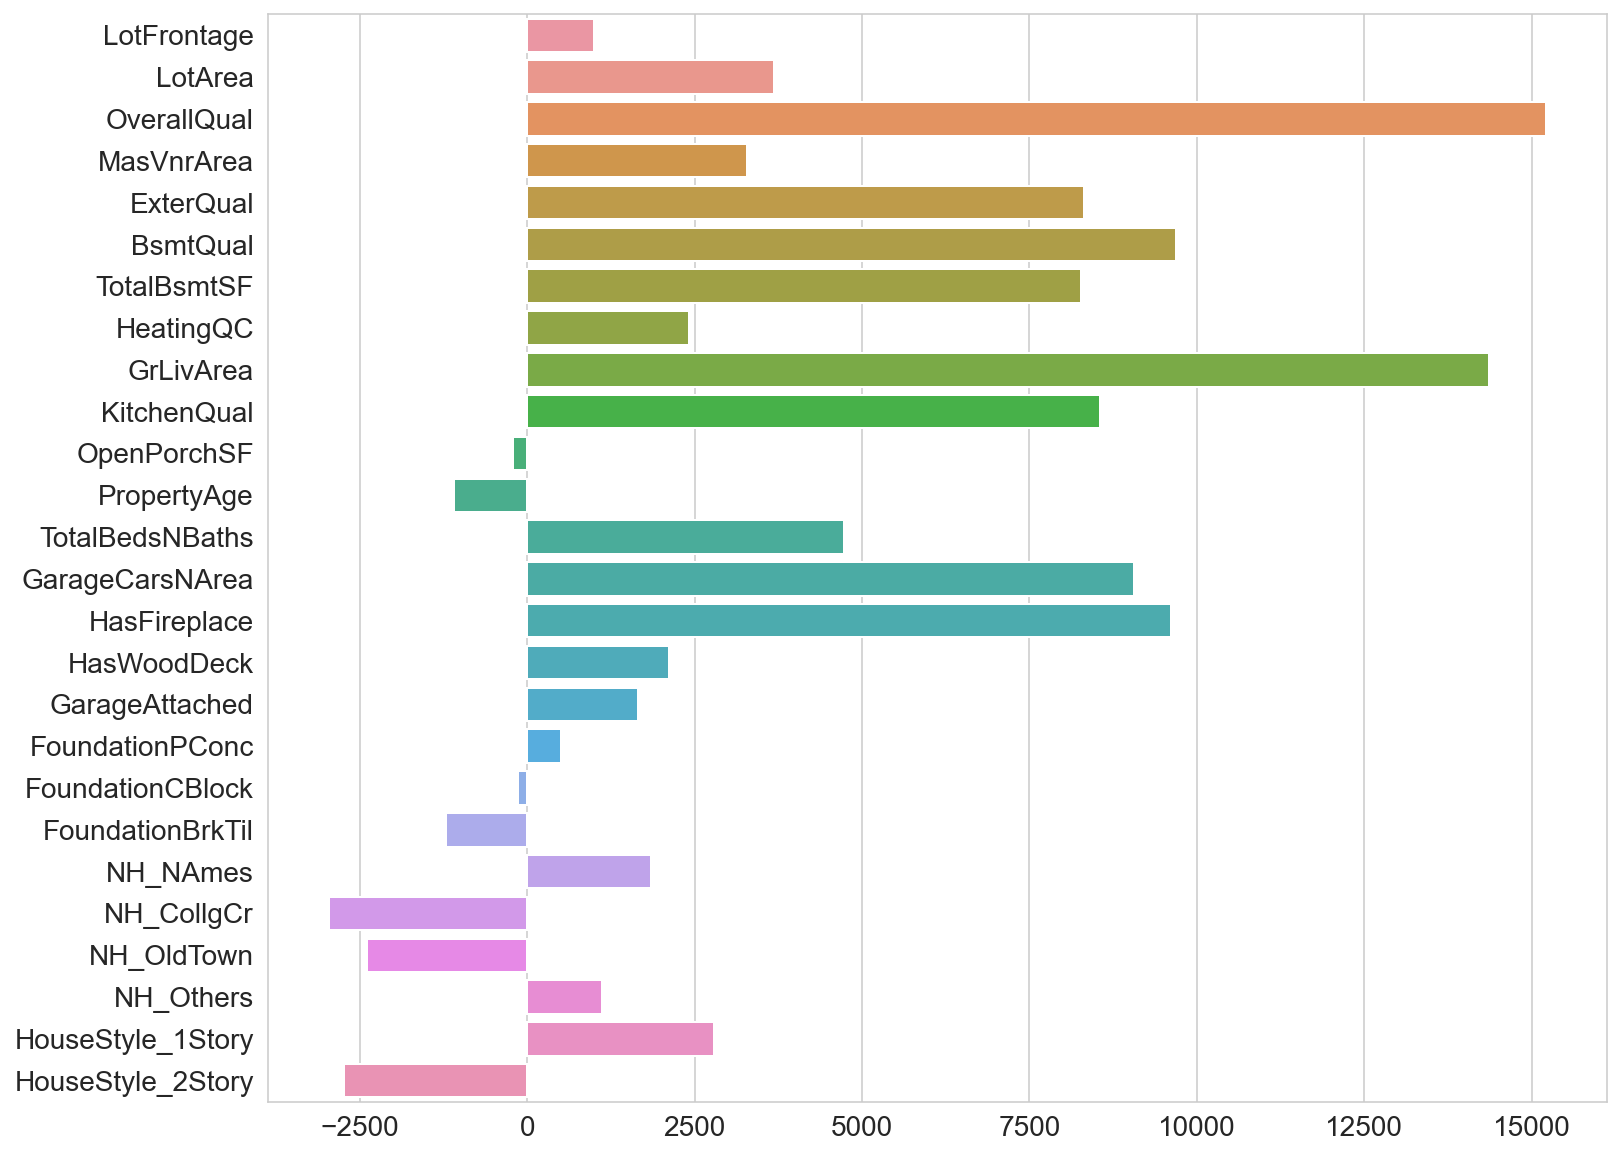

In [56]:
# Plot the coefficients
res = pd.DataFrame(best_ridge.coef_, columns=['Coefficient'], index=X_train.columns).T

plt.figure(figsize=(12, 10))
# plt.xticks(rotation=90)
plt.title('Coefficients for Ridge model')
sns.barplot(data=res, orient='h');

The coefficient values are similar to the scaled value model for MLR.

### 3.3 Lasso Regression

In [57]:
# Instantiate and fit the model
lassocv = LassoCV(n_alphas=200)
lassocv.fit(X_train_sc, y_train)

LassoCV(n_alphas=200)

In [58]:
# optimal alpha value
lassocv.alpha_

929.4237685572134

#### Cross-validate with best Lasso

In [59]:
# Instantiate the best_lasso model with optimal alpha
best_lasso = Lasso(alpha=lassocv.alpha_)

In [60]:
# Mean cross validation score with best lasso model
np.sqrt(-cross_val_score(best_lasso, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error').mean())

33385.82520677307

In [61]:
# Fit the best Lasso model
best_lasso.fit(X_train_sc, y_train)

Lasso(alpha=929.4237685572134)

In [62]:
# Print the performance metrics -- train set
get_reg_metrics(_model=best_lasso, _X=X_train_sc, _y=y_train)

R-squared: 0.82958 | Ajusted R-squared: 0.8259
Mean absolute error: 20516.75332
Root mean squared error: 31792.82291


In [63]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=best_lasso, _X=X_valid_sc, _y=y_valid)

R-squared: 0.84992 | Ajusted R-squared: 0.84501
Mean absolute error: 21848.96883
Root mean squared error: 31917.15666


The updated error table is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|<span style="color:blue">MLR</span>|  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|MLR (poly) |  Set II                 |  18899.71  |  33070.58  |   0.93978 / 0.83888   |       -        |
|   Ridge   |  Set II                 |  31605.43  |  31627.59  |   0.83159 / 0.85263   |    33321.36    |
|   Lasso   |  Set II                 |  31792.82  |  31917.15  |   0.82958 / 0.84992   |    33385.82    |

A slight improvement over ridge regression but not much that we can declare this the best model yet. The main advantage Lasso regularization has over ridge is that it can be aggresive to penalize the coefficients, so its a great tool to filter out less significant features.

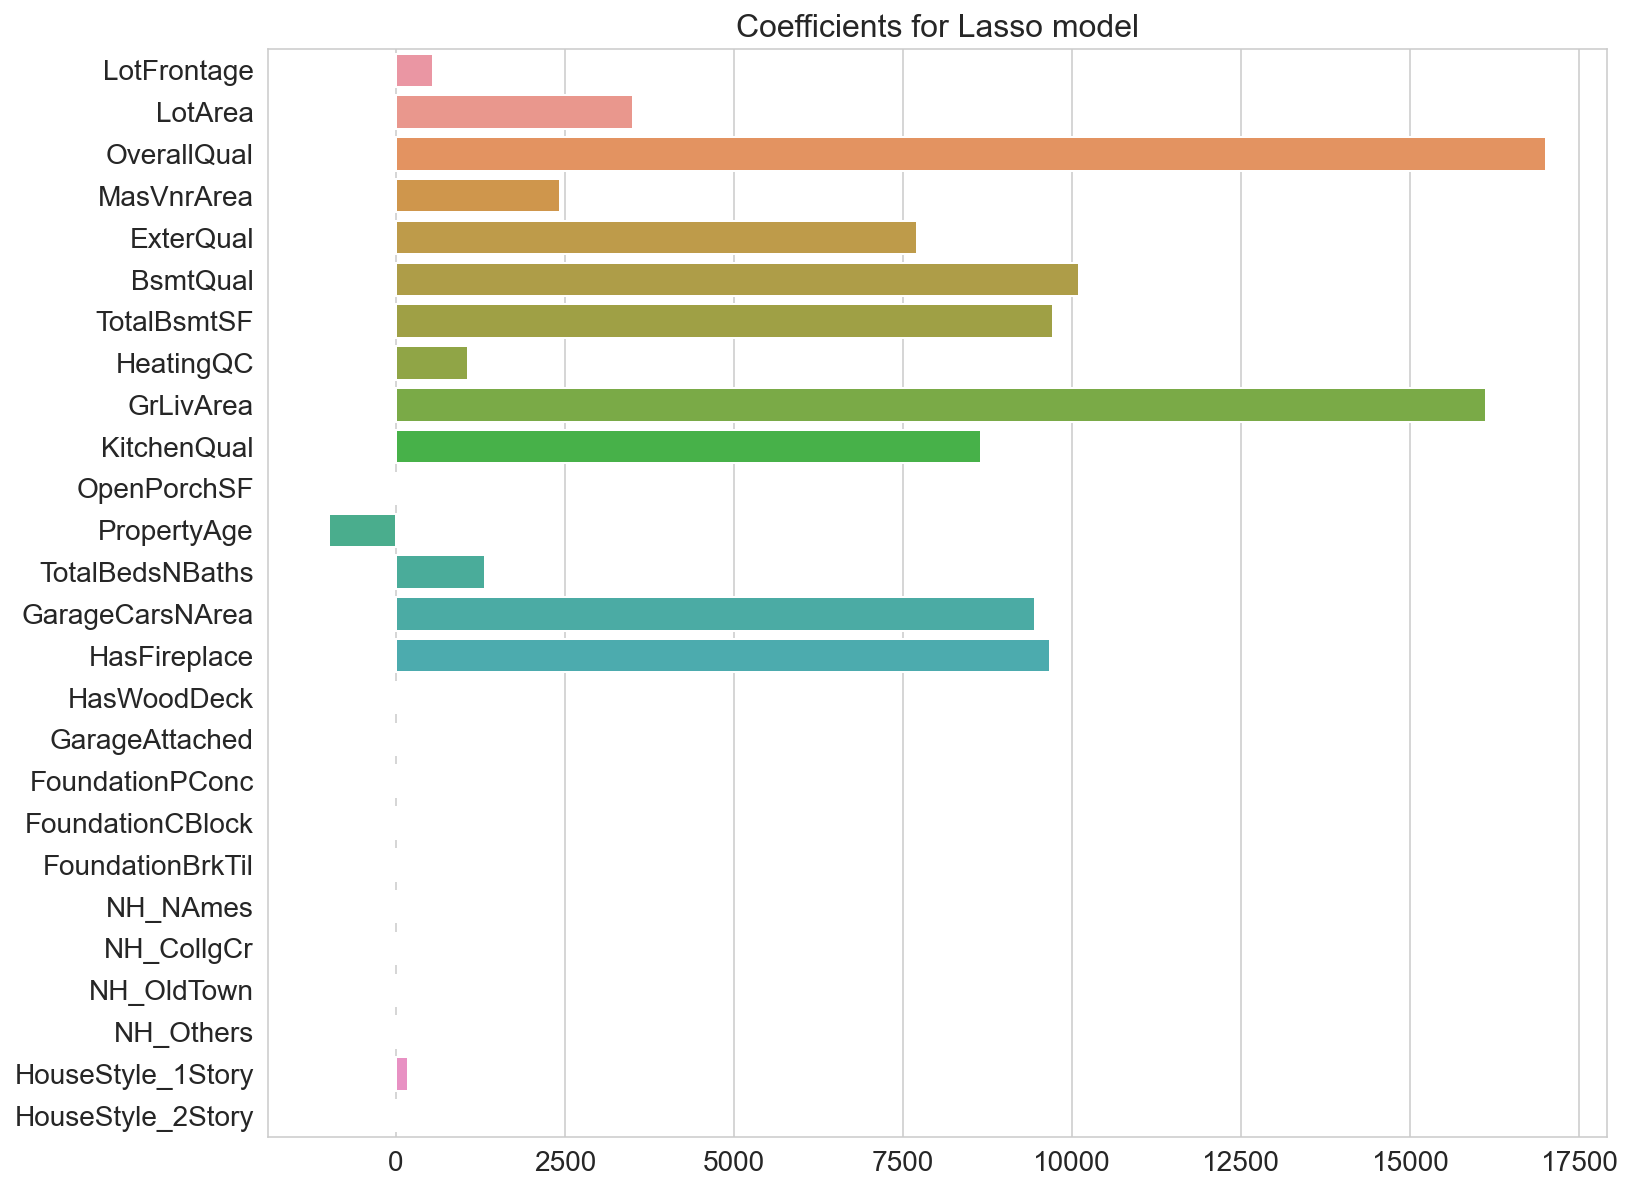

In [88]:
# Plot the coefficients
res = pd.DataFrame(best_lasso.coef_, columns=['Coefficient'], index=X_train.columns).T

plt.figure(figsize=(12, 10))
# plt.xticks(rotation=90)
plt.title('Coefficients for Lasso model')
sns.barplot(data=res, orient='h');

As can be seem from the plot above, many of the coefficients are zeroed. This is really useful when you have many variables and you want to perform feature selection, like when we use polynomial features, we get so many features that it becomes difficult to make sense of even though you might get good results. Lasso regression helps us _filter out_ the features that do not contribute much to predicting target variable. Next, let's fit the lasso model with polynomial feature interaction.

#### Lasso with polynomial features

In [65]:
# Instantiate and fit the model
lassocv_poly = LassoCV(n_alphas=200)
lassocv_poly.fit(X_train_poly, y_train)

LassoCV(n_alphas=200)

In [66]:
# optimal alpha value
lassocv_poly.alpha_

1860.8926149794945

In [67]:
# Instantiate the best_lasso model with optimal alpha
best_lasso_poly = Lasso(alpha=lassocv_poly.alpha_)

In [68]:
# Mean cross validation score with best lasso model
np.sqrt(-cross_val_score(best_lasso_poly, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error').mean())

31003.54347443054

In [69]:
# Fit the best Lasso model
best_lasso_poly.fit(X_train_poly, y_train)

Lasso(alpha=1860.8926149794945)

In [70]:
# Print the performance metrics -- train set
get_reg_metrics(_model=best_lasso_poly, _X=X_train_poly, _y=y_train)

R-squared: 0.89905 | Ajusted R-squared: 0.85869
Mean absolute error: 16844.8729
Root mean squared error: 24470.15612


In [71]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=best_lasso_poly, _X=X_valid_poly, _y=y_valid)

R-squared: 0.8796 | Ajusted R-squared: 0.78949
Mean absolute error: 18948.82924
Root mean squared error: 28587.87893


In [72]:
# Check how many coefficients are zeroed
(best_lasso_poly.coef_ == 0).sum(), best_lasso_poly.coef_.shape[0]

(306, 351)

This is where the Lasso shines, as we discussed previously, it filtered out 306 feature terms out of 351 from the polynomial feature interaction input we fitted to the model. We also get significant improvement in the model performance with $RMSE$ for train as low as $24470.15$ and valid as $28587.87$. The cross-validation score of $31003.54$ is a good indicator that the model hold grounds on data not yet seen by the model. The updated error table is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|    MLR    |  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|MLR (poly) |  Set II                 |  18899.71  |  33070.58  |   0.93978 / 0.83888   |       -        |
|   Ridge   |  Set II                 |  31605.43  |  31627.59  |   0.83159 / 0.85263   |    33321.36    |
|   Lasso   |  Set II                 |  31792.82  |  31917.15  |   0.82958 / 0.84992   |    33385.82    |
|<span style="color:blue">Lasso (poly)</span>|  Set II                 |  24470.15  |  28587.87  |   0.89905 / 0.8796    |    31003.54    |

The Lasso with polynomial features is the best model yet.

### 3.4 ElasticNet Regression

In [73]:
# Instantiate and fit the model
l1_ratios = np.linspace(0.01, 1.0, 25)
elasticnetcv = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,)
elasticnetcv.fit(X_train_sc, y_train)

ElasticNetCV(cv=10,
             l1_ratio=array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ]))

In [74]:
# Optimal alpha and l1_ratio
print(elasticnetcv.alpha_)
print(elasticnetcv.l1_ratio_)

819.4953599703271
1.0


After trying different values, we keep getting `l1_ratio` of $1.0$, meaning the elasticnet models predicts we would get best results with lasso regression. This might make sense because we have many features in the model that are not so significant indicators of target value prediction.

#### Cross-validate with best ElasticNet

In [75]:
# Instantiate the elasticnet with alpha and l1_ratio
elasticnet = ElasticNet(alpha=elasticnetcv.alpha_, l1_ratio=elasticnetcv.l1_ratio_)

In [76]:
# Mean cross validation score with elasticnet model
np.sqrt(-cross_val_score(elasticnet, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error').mean())

33379.99581679395

In [77]:
# Fit the best elasticnet model
elasticnet.fit(X_train_sc, y_train)

ElasticNet(alpha=819.4953599703271, l1_ratio=1.0)

In [78]:
# Print the performance metrics -- train set
get_reg_metrics(_model=elasticnet, _X=X_train_sc, _y=y_train)

R-squared: 0.83003 | Ajusted R-squared: 0.82636
Mean absolute error: 20499.06394
Root mean squared error: 31751.30268


In [79]:
# Print the performance metrics -- valid set
get_reg_metrics(_model=elasticnet, _X=X_valid_sc, _y=y_valid)

R-squared: 0.85051 | Ajusted R-squared: 0.84562
Mean absolute error: 21809.3721
Root mean squared error: 31854.10602


So it is no surprice that we get similar values to Lasso with ElasticNet. Perhaps a revisit to features could improve but we move on with this for now. The error table is as follows:

| Predictor |        Features         | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:---------:|:-----------------------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline  | _SalePrice_ ($\hat{y}$) |  77014.97  |  82507.10  |            -          |        -       |
|    SLR    |  _Lot Area_             |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|    MLR    |  Set II                 |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|MLR (poly) |  Set II                 |  18899.71  |  33070.58  |   0.93978 / 0.83888   |       -        |
|   Ridge   |  Set II                 |  31605.43  |  31627.59  |   0.83159 / 0.85263   |    33321.36    |
|   Lasso   |  Set II                 |  31792.82  |  31917.15  |   0.82958 / 0.84992   |    33385.82    |
|<span style="color:blue">Lasso (poly)</span>|  Set II                 |  24470.15  |  28587.87  |   0.89905 / 0.8796    |    31003.54    |
| ElasticNet|  Set II                 |  31751.30  |  31854.10  |    0.83003 / 0.85051   |    33379.99    |

The best model is still Lasso with polynomial features.

## 4 Production Model

Before declaring the best model as the production model, we can make a point that we can choose the MLR as the best model so far to predict the target variable, if we had to present it to stakeholders who might be interested in knowing how it works "under the hood". However, for production model, we only care about the best performer, which is arguable the _Lasso model w/ polynomial features_. We note this because the features whose coefficients were zeroed by the Lasso regression has to be looked at in detail to understand the interactions and the cycle can be repeated for better feature engineering.

In the project, from the table above, we can make a decision to choose the best model for production based on the $RMSE$ and $R^2$ values, which is the _Lasso model w/ polynomial features_. Let's fit the model with entire __training__ dataset available at hand to make the best predictions for the _SalePrice_ in test data and get the $RMSE$ values from kaggle.

In [80]:
# Concatenate the train and valid sets into one
X_full_train_poly = pd.concat([pd.DataFrame(X_train_poly), pd.DataFrame(X_valid_poly)])
y_full_train = pd.concat([y_train, y_valid])

In [81]:
# Get the new optimal alpha for the whole train dataset
lassocv_poly = LassoCV(n_alphas=200, cv=10)
lassocv_poly.fit(X_full_train_poly, y_full_train)

prod_lasso_poly = Lasso(alpha=lassocv_poly.alpha_)

Let's train the _best model_ on all the __training__ data available so as to make predictions for the target variable in __test__ dataset to get the actual $RMSE$ value from kaggle.

In [82]:
# Fit the best model with full training data
prod_lasso_poly.fit(X_full_train_poly, y_full_train)

Lasso(alpha=948.8993220071698)

In [83]:
# Print the performance metrics -- train set
get_reg_metrics(_model=prod_lasso_poly, _X=X_full_train_poly, _y=y_full_train)

R-squared: 0.90547 | Ajusted R-squared: 0.88594
Mean absolute error: 16584.37266
Root mean squared error: 24362.76517


In [84]:
# Mean cross validation score with elasticnet model
np.sqrt(-cross_val_score(prod_lasso_poly, X_full_train_poly, y_full_train, cv=10, scoring='neg_mean_squared_error').mean())

29308.337497046326

The errors and scores are replicated here, only better, compared to previous iteration of Lasso, as we train the model on entire training data available to us. The cross-validation score has improved then before because now we simply have more observations to train the model on. The $RMSE$ is $24362.76$ and $MAE$ has also decresed to $16584.37$

Finally, we use this model to make predictions for the _SalePrice_ in test data and upload to kaggle to get the final $RMSE$ of $\textbf{\$28435.67}$, which is very close to the valid data from lasso poly above, and we can evidently say that this model is performing very well.

In [85]:
get_kaggle_format(model_type='lasso', predictions=prod_lasso_poly.predict(X_test_poly), return_df=True)

,Id,SalePrice
704,2,129063.156730
706,4,267849.068375
120,6,183430.415384
312,7,202958.349692
401,17,210946.406292
...,...,...
537,2919,83836.984796
179,2921,85921.317134
829,2922,180549.775520
669,2925,144479.693342


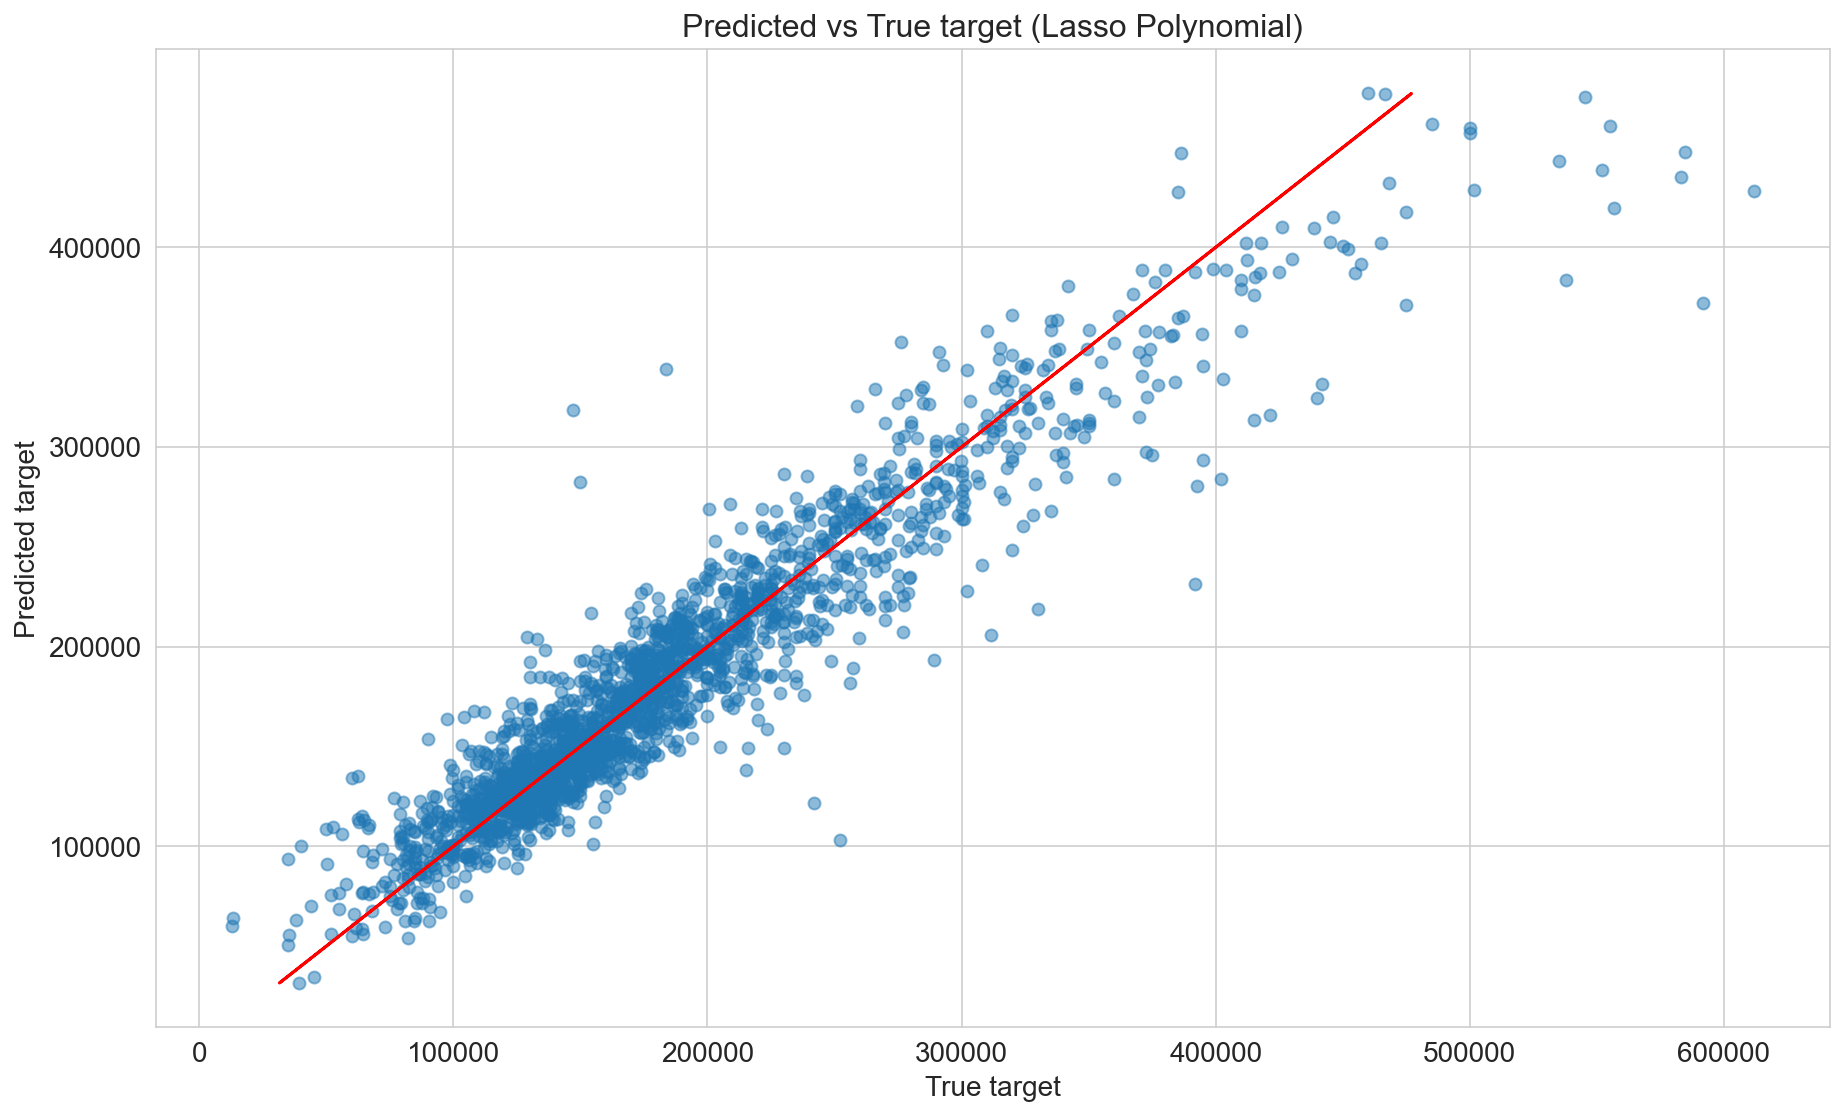

In [86]:
# Plot the predicted vs true target value for the best model
plt.figure(figsize=(15,9))
plt.scatter(x=y_full_train, alpha=0.5, y=best_lasso_poly.predict(X_full_train_poly))
plt.title('Predicted vs True target (Lasso Polynomial)')
plt.xlabel('True target')
plt.ylabel('Predicted target')
plt.plot(best_lasso_poly.predict(X_full_train_poly), best_lasso_poly.predict(X_full_train_poly), 'r');

This plot shows the predictions our model made vs the true values for the entire training data. The red line shows our prediction linearly predicting the true values. We don't see any irregularities except for the higher variance at higher prices adn this could be that we might not have enough data for high value properties. But our _best model_ predicts bulk of the values very accurately.

## 5 Conclusions & Recommendations

In this project, we went through a whole lot of exploring & modeling, and understanding how selecting features, their interactions and knowing relationship between them and target variable can affect the results. In the end, we made a production ready model from polynomial features using Lasso regularization regression getting an $RMSE$ of $\$24362.76$ on the entire training data and $\$28435.67$ on the test data from kaggle.

The project deals with housing data from the city of Ames, Iowa. It consists of quantified details about property sales from 2006 to 2010, and we are tasked to use the features to predict sale price of the properties using various Linear Regression methods. We began the project by getting the orginal dataset from kaggle. It consisted of $80$ features, many of which had numerous null values and couldn't be used for regression models.

We performed EDA on all types of data $-$ numerical, ordinal and categorical. Many of the categorical columns that had no variety in data were not used in the model as they would contribute very little to the model building. Some features had interdependent relationships and they were dealth with by either combing them into single column or converting them to binary columns. We selected features based on evidence and dropped those that were thought not be siginificant for model training. We even revisited feature selection after seeing inital model results. Finally, $26$ distinct features were selected for building the models.

A baseline score was established, and then different linear regression models were built and compared on metrics like, $R^2$ and $MAE$, but mainly $RMSE$. The performance of selected models is shown in the table below:

| Predictor  | Train RMSE | Valid RMSE | Train / Valid ($R^2$) | Cross val RMSE |
|:----------:|:----------:|:----------:|:---------------------:|:--------------:|
| Baseline   |  77014.97  |  82507.10  |            -          |        -       |
|    SLR     |  72827.35  |  75595.17  |   0.10579 / 0.15811   |    73073.10    |
|    MLR     |  31475.19  |  31181.94  |   0.83287 / 0.85699   |    33546.18    |
|   Ridge    |  31605.43  |  31627.59  |   0.83159 / 0.85263   |    33321.36    |
|   Lasso    |  31792.82  |  31917.15  |   0.82958 / 0.84992   |    33385.82    |
|Lasso (poly)|  24470.15  |  28587.87  |   0.89905 / 0.8796    |    31003.54    |
| ElasticNet |  31751.30  |  31854.10  |   0.83003 / 0.85051   |    33379.99    |

The __production model__ that had the best performance was Lasso regularized regression with polynomial features. The polynomial features creates many interaction terms, 351 to be precise, and it is not always easy to interpret how each term affects the target, _SalePrice_ in this case. Therefore, we use Lasso and saw that about 306 coefficients were zeroed, hence the remaining features can be looked in detail in feature along with other features that were not part of modeling in this project.

The top five features, taken from MLR, that have the most impact on _SalePrice_ of the house are:

|   Feature 	| BsmtQual 	| ExterQual | KitchenQual |	HasFireplace | OverallQual |
|---------------|-----------|-----------|-------------|--------------|-------------|
|**Coefficient**| 16061.081 | 14064.274 |  13085.968  |	11930.744 	 | 11844.361   |

These values mean each unit increment in the feature value raises the house price by its respective coefficient value. Four of the top five coefficients are quality measures, so we would recommend any property seller to improve those ratings to get a better value for their real estate. Based on our analsis, some features that might not be as significant in determining the price are: _open porch, wood deck, garage type, foundation, neighborhood and house style_.

With more detailed feature engineering, which can be time-consuming yet fruitful, and exploring the underlying relationship among features and between target variable, a more accurate low error regression model can be developed in the future. For the purpose of this project, our production model would suffice based on our predictions.